
# PyTorch Lightning CIFAR10


## Setup
This notebook requires some packages besides pytorch-lightning.

In [ ]:
! pip install --quiet "lightning-bolts"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.9 MB/s eta 0:00:00


In [ ]:
!pip install --quiet "torchmetrics>=0.6"

In [ ]:
# Run this if you intend to use TPUs
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

In [ ]:
import os
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.core.display import display
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.functional import accuracy

seed_everything(7)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

/usr/local/lib/python3.10/dist-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.10/dist-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The featu

### CIFAR10 Data Module

Import the existing data module from `bolts` and modify the train and test transforms.

In [ ]:

train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

cifar10_dm = CIFAR10DataModule(
    data_dir=PATH_DATASETS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=test_transforms,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Resnet
Modify the pre-existing Resnet architecture from TorchVision. The pre-existing architecture is based on ImageNet
images (224x224) as input. So we need to modify it for CIFAR10 images (32x32).

In [ ]:
def create_model():
    model = torchvision.models.resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model

### Lightning Module
Check out the [`configure_optimizers`](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html#configure-optimizers)
method to use custom Learning Rate schedulers. The OneCycleLR with SGD will get you to around 92-93% accuracy
in 20-30 epochs and 93-94% accuracy in 40-50 epochs. Feel free to experiment with different
LR schedules from https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [ ]:
class LitModel(LightningModule):
  def __init__(self, num_classes = 10, data_dir= PATH_DATASETS, lr=0.01):
    super(LitModel,self).__init__()
    self.save_hyperparameters()

    #class attributes
    self.EPOCHS = 25
    self.learning_rate = 0.05
    self.num_classes= 10
    self.data_dir = PATH_DATASETS
    self.save_hyperparameters()
    self.model = create_model()

    # Prep Layer
    self.convblock1 = nn.Sequential( nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU()
                                      )

    # CONVOLUTION BLOCK 1
    self.convblock2 = nn.Sequential( nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU()
      )

    self.R1 = nn.Sequential(nn.Conv2d (in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=128,  out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
                            nn.BatchNorm2d(128),
                            nn.ReLU())



    # CONVOLUTION BLOCK 2
    self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU()
                                    )

    # CONVOLUTION BLOCK 3
    self.convblock4 = nn.Sequential(nn.Conv2d(256, 512, 3,padding=1, bias=False),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU()
          )

    self.R2  = nn.Sequential(nn.Conv2d (in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
                              nn.BatchNorm2d(512),
                              nn.ReLU(),
                              nn.Conv2d (in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
                              nn.BatchNorm2d(512),
                              nn.ReLU()
          )

    self.maxpool = nn.MaxPool2d(kernel_size=4)

    self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, self.num_classes)


  def forward(self, x):
      x = self.convblock1(x)
      x = self.convblock2(x)
      x = self.R1(x) + x
      x = self.convblock3(x)
      x = self.convblock4(x)
      x= self.R2(x) + x
      x = self.maxpool(x)
      x = self.global_pool(x)
      # print(x.shape)
      x = x.view(x.size(0), -1)

      x = self.fc(x)
      return F.log_softmax(x, dim=-1)

  def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

  def evaluate(self, batch, stage=None):
      x, y = batch
      logits = self(x)
      loss = F.nll_loss(logits, y)
      preds = torch.argmax(logits, dim=1)
      acc = accuracy(preds, y,task='MULTICLASS',  num_classes=10)

      if stage:
          self.log(f"{stage}_loss", loss, prog_bar=True)
          self.log(f"{stage}_acc", acc, prog_bar=True)

  def validation_step(self, batch, batch_idx):
      self.evaluate(batch, "val")

  def test_step(self, batch, batch_idx):
      self.evaluate(batch, "test")

  def configure_optimizers(self):
      optimizer = torch.optim.SGD(
          self.parameters(),
          lr=self.hparams.lr,
          momentum=0.9,
          weight_decay=5e-4,
      )
      steps_per_epoch = 45000 // BATCH_SIZE
      scheduler_dict = {
          "scheduler": OneCycleLR(
              optimizer,
              0.1,
              epochs=self.trainer.max_epochs,
              steps_per_epoch=steps_per_epoch,
          ),
          "interval": "step",
      }
      return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [ ]:
class LitResnet(LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model()

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y,task='MULTICLASS',  num_classes=10)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        steps_per_epoch = 45000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [ ]:
model = LitResnet(lr=0.05)

trainer = Trainer(
    max_epochs=10,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(model, cifar10_dm)
trainer.test(model, datamodule=cifar10_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Testing: 0it [00:00, ?it/s]

In [ ]:
model_1 = LitModel(lr=0.05)

trainer1 = Trainer(
    max_epochs=40,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)

trainer1.fit(model_1, cifar10_dm)
trainer1.test(model_1, datamodule=cifar10_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type              | Params
--------------------------------------------------
0 | model       | ResNet            | 11.2 M
1 | convblock1  | Sequential        | 1.9 K 
2 | convblock2  | Sequential        | 74.0 K
3 | R1          | Sequential        | 295 K 
4 | convblock3  | Sequential        | 295 K 
5 | convblock4  | Sequential        | 1.2 M 
6 | R2          | Sequential        | 4.7 M 
7 | maxpool     | MaxPool2d         | 0     
8 | global_pool | AdaptiveAvgPool2d | 0     
9 | fc          | Linear            | 5.1 K 
--------------------------------------------------
17.7 M    Trainable params
0         Non-trainable params
17.7 M    Total params
70.988    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9276999831199646     │
│         test_loss         │    0.2781853675842285     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2781853675842285, 'test_acc': 0.9276999831199646}]

In [ ]:
model_1 = LitModel(lr=0.05)

trainer1 = Trainer(
    max_epochs=10,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)

trainer1.fit(model_1, cifar10_dm)
trainer1.test(model_1, datamodule=cifar10_dm)

In [ ]:
trainer.save_checkpoint("/content/drive/MyDrive/ERA V2/Session_13/Weights/best_model_sample.ckpt")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainer1.save_checkpoint("/content/drive/MyDrive/ERA V2/Session_13/Weights/best_model_litmodel_92_acc.ckpt")

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
model = LitModel(lr=0.05).load_from_checkpoint("/content/drive/MyDrive/ERA V2/Session_13/Weights/best_model_litmodel_92_acc.ckpt")

,lr-SGD,train_loss,val_loss,val_acc,test_loss,test_acc
epoch,,,,,,
NaN,0.006056,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.866115,NaN,NaN,NaN,NaN
NaN,0.012210,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.642991,NaN,NaN,NaN,NaN
NaN,0.021912,NaN,NaN,NaN,NaN,NaN


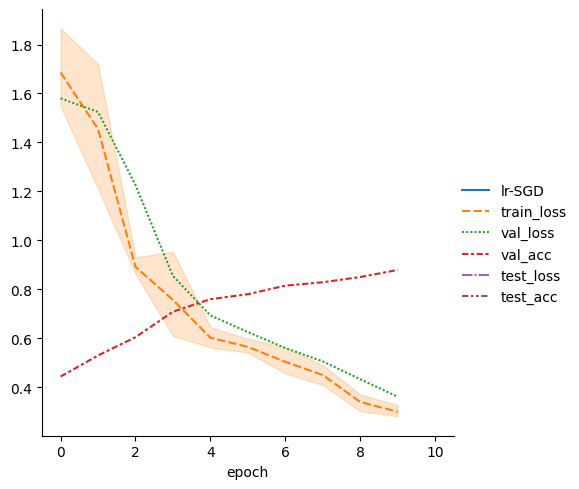

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [ ]:
!pip install gradio
!pip install --upgrade gradio

In [ ]:
# Install GradCam
%pip install grad-cam

In [ ]:
def display_cifar_misclassified_data(data: list,
                                     classes: list[str],
                                     inv_normalize: transforms.Normalize,
                                     number_of_samples: int = 10):
    """
    Function to plot images with labels
    :param data: List[Tuple(image, label)]
    :param classes: Name of classes in the dataset
    :param inv_normalize: Mean and Standard deviation values of the dataset
    :param number_of_samples: Number of images to print
    """
    fig = plt.figure(figsize=(10, 10))
    img = None
    x_count = 5
    y_count = 1 if number_of_samples <= 5 else math.floor(number_of_samples / x_count)

    for i in range(number_of_samples):
        plt.subplot(y_count, x_count, i + 1)
        img = data[i][0].squeeze().to('cpu')
        img = inv_normalize(img)
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.title(r"Correct: " + classes[data[i][1].item()] + '\n' + 'Output: ' + classes[data[i][2].item()])
        plt.xticks([])
        plt.yticks([])
    plt.savefig('imshow_output.png')
    return 'imshow_output.png'


Files already downloaded and verified
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


'imshow_output.png'

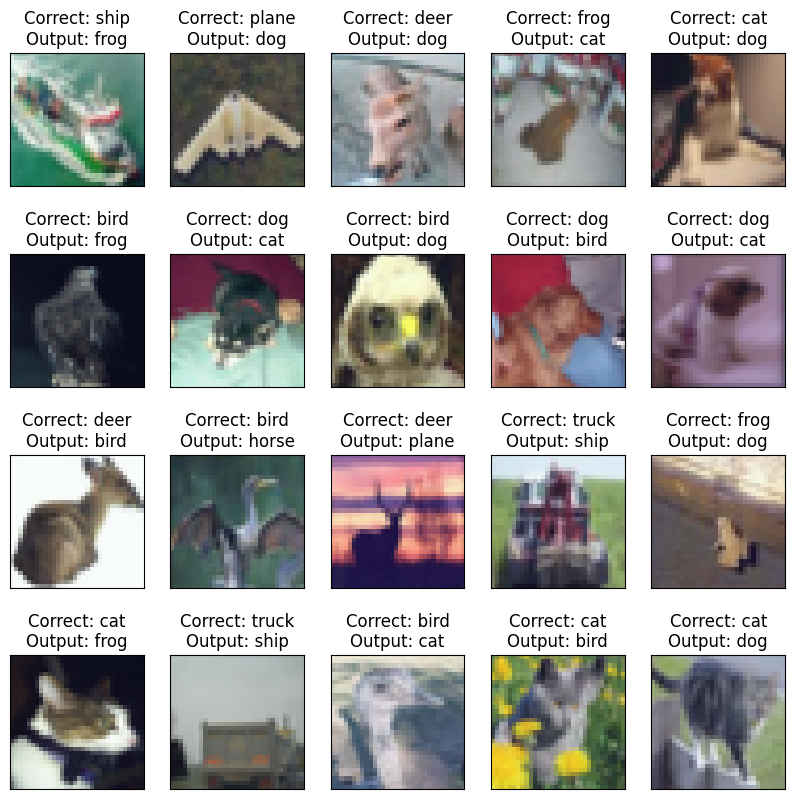

In [ ]:
# Yes - This is important predecessor1 for gradioMisClass
import numpy as np
import gradio as gr
from PIL import Image
import math
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import datasets, transforms, utils

targets = None
device = torch.device("cpu")
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


cifar10_dm.prepare_data()
cifar10_dm.setup()
test_loader = cifar10_dm.test_dataloader()


def get_misclassified_data2(model, device, test_loader, count):
    """
    Function to run the model on test set and return misclassified images
    :param model: Network Architecture
    :param device: CPU/GPU
    :param test_loader: DataLoader for test set
    """

    # Prepare the model for evaluation i.e. drop the dropout layer
    model.eval()

    # List to store misclassified Images
    misclassified_data = []

    # Reset the gradients
    with torch.no_grad():
        # Extract images, labels in a batch
        for data, target in test_loader:

            # Migrate the data to the device
            data, target = data.to(device), target.to(device)

            # Extract single image, label from the batch
            for image, label in zip(data, target):

                # Add batch dimension to the image
                image = image.unsqueeze(0)

                # Get the model prediction on the image
                output = model(image)

                # Convert the output from one-hot encoding to a value
                pred = output.argmax(dim=1, keepdim=True)

                # If prediction is incorrect, append the data
                if pred != label:
                    misclassified_data.append((image, label, pred))

                if len(misclassified_data) > count :
                  break
    return misclassified_data

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)

# Get the misclassified data from test dataset
misclassified_data = get_misclassified_data2(model, device, test_loader, 20)



# Plot the misclassified data
display_cifar_misclassified_data(misclassified_data, classes, inv_normalize, number_of_samples=20)

In [ ]:
# This demo needs to be run from the repo folder.
# python demo/fake_gan/run.py
import random

import gradio as gr


def fake_gan():
    fileName = display_cifar_misclassified_data(misclassified_data, classes, inv_normalize, number_of_samples=5)

    images = [
        (random.choice(
            [
                display_cifar_misclassified_data(misclassified_data, classes, inv_normalize, number_of_samples=5),
                Image.open(fileName)
            ]
        ), f"label {i}")
        for i in range(3)
    ]
    return images



with gr.Blocks() as demo:
    gallery = gr.Gallery(
        label="Generated images", show_label=False, elem_id="gallery"
    , columns=[3], rows=[1], object_fit="contain", height="auto")
    btn = gr.Button("Generate images", scale=0)

    btn.click(fake_gan, None, gallery)

if __name__ == "__main__":
    demo.launch()

/usr/local/lib/python3.10/dist-packages/gradio/routes.py:1097: DeprecationWarning: 
        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        
  @app.on_event("startup")
/usr/local/lib/python3.10/dist-packages/fastapi/applications.py:4495: DeprecationWarning: 
        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        
  return self.router.on_event(event_type)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c456a2dc03399ea503.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
 v